In [1]:
# We don't technically need this but it avoids a warning when importing pysis
import os
os.environ['ISISROOT'] = '/usgs/cpkgs/anaconda3_linux/envs/isis3.9.0'

<a id='toc'></a>
# AutoCNet Intro
As mentioned earlier AutoCNet is a method for storing control networks and has outlier detection functionality. AutoCNet also contains a suite of functions that parallelize network generation that leverages and compliments ISIS processing. The advantage of AutoCNet network generation is it takes advantage of elementwise cluster processing (these elements can be images, points, measures, etc.) and postgresql for data storage and quick relational querying. 

In this notebook we are going to step through the network generation process in AutoCNet!

For Quick Access:
- [Load and apply configuration file](#configuration)
- [Ingest images and calculate overlaps](#ingest)
- [Distribute points in overlaps](#distribute)
- [Subpixel register points](#registration)

### Grab the Image Data
We are going to process Kaguya Terrian Camera (TC) images surrounding the Reiner Gamma Lunar Swirl (4.9° - 9.9° N Planetocentric Latitude and 61.3° - 56.3° W Longitude). The data is located in '/scratch/ladoramkershner/moon/kaguya/workshop/original/', please use the cell below to copy the data into a directory of your choosing.

In [2]:
import getpass
uid = getpass.getuser()

output_directory = f'/scratch/ladoramkershner/FY21_autocnet_workshop/workshop_scratch/{uid}' # put output directory path as string here
print(output_directory)

/scratch/ladoramkershner/FY21_autocnet_workshop/workshop_scratch/ladoramkershner


In [3]:
# copy over the data to the 'lvl1' subdirectory
!mkdir -p $output_directory/lvl1/ 
!cp -p /scratch/ladoramkershner/moon/kaguya/workshop/original/*cub $output_directory/lvl1/

We need to create a list of the cubes, to feed into AutoCNet. It is important that the cube list handed to AutoCNet contain **absolute** paths, as they will serve as an accessor for loading information from the cubes later.

In [4]:
!ls $output_directory/lvl1/*cub > $output_directory/cubes.lis
!head $output_directory/cubes.lis

/scratch/ladoramkershner/FY21_autocnet_workshop/workshop_scratch/ladoramkershner/lvl1/TC1W2B0_01_00570N049E3038.cub
/scratch/ladoramkershner/FY21_autocnet_workshop/workshop_scratch/ladoramkershner/lvl1/TC1W2B0_01_00570N063E3038.cub
/scratch/ladoramkershner/FY21_autocnet_workshop/workshop_scratch/ladoramkershner/lvl1/TC1W2B0_01_00570N076E3038.cub
/scratch/ladoramkershner/FY21_autocnet_workshop/workshop_scratch/ladoramkershner/lvl1/TC1W2B0_01_00570N090E3038.cub
/scratch/ladoramkershner/FY21_autocnet_workshop/workshop_scratch/ladoramkershner/lvl1/TC1W2B0_01_00570N103E3038.cub
/scratch/ladoramkershner/FY21_autocnet_workshop/workshop_scratch/ladoramkershner/lvl1/TC1W2B0_01_02742N045E3036.cub
/scratch/ladoramkershner/FY21_autocnet_workshop/workshop_scratch/ladoramkershner/lvl1/TC1W2B0_01_02742N059E3036.cub
/scratch/ladoramkershner/FY21_autocnet_workshop/workshop_scratch/ladoramkershner/lvl1/TC1W2B0_01_02742N072E3036.cub
/scratch/ladoramkershner/FY21_autocnet_workshop/workshop_scratch/ladoram

<a id='configuration'></a>
# Parse the Configuration File
[Return To Top](#toc)


The configuration parameters are typically held in a configuration yaml file. A configuration file has been compiled for use internal to the USGS ASC facilities leveraging a shared cluster and database. Use AutoCNet's function 'parse_config' to read in the yaml file and output a dictionary variable.

In [5]:
from autocnet.config_parser import parse_config

config_path = '/scratch/ladoramkershner/FY21_autocnet_workshop/config_moon.yml'
config = parse_config(config_path)

The config is a nested dictionary, meaning it has a larger dictionary structure defining sections for the services above and then each service section is a dictionary defining the particular configuration parameters.

In [6]:
import numpy as np 

print('configuration dictionary keys: ')
print(np.vstack(list(config.keys())), '\n')

print('cluster configuration dictionary keys: ')
print(np.vstack(list(config['cluster'].keys())))

configuration dictionary keys: 
[['cluster']
 ['database']
 ['env']
 ['pfeffernusse']
 ['redis']
 ['spatial']] 

cluster configuration dictionary keys: 
[['maxfailures']
 ['queue']
 ['cluster_log_dir']
 ['cluster_submission']
 ['tmp_scratch_dir']
 ['extractor_memory']
 ['processing_memory']]


Although the configuration file is set up for internal use, some fields need to be altered to point to user specific areas or unique strings.

In [7]:
config['cluster']['cluster_log_dir'] = f'/scratch/ladoramkershner/FY21_autocnet_workshop/workshop_scratch/{uid}/logs'
config['database']['name'] = f'workshop_{uid}_kaguyatc_reinergamma'
config['redis']['basename'] = f'{uid}_queue'
config['redis']['completed_queue'] = f'{uid}_queue:comp'
config['redis']['processing_queue'] = f'{uid}_queue:proc'
config['redis']['working_queue'] = f'{uid}_queue:work'

In [8]:
default_log = config['cluster']['cluster_log_dir']

print(f'your log directory: {default_log}')
print('your database name:', config['database']['name'])

your log directory: /scratch/ladoramkershner/FY21_autocnet_workshop/workshop_scratch/ladoramkershner/logs
your database name: workshop_ladoramkershner_kaguyatc_reinergamma


### Create the NetworkCandidateGraph
The NetworkCandidateGraph (NCG) class can be instantiated to an object without any arguments. However, this NCG object requires configuration before it can be used for any meaningful work, so we have to run 'config_from_dict'.

In [9]:
from autocnet.graph.network import NetworkCandidateGraph

ncg = NetworkCandidateGraph()
ncg.config_from_dict(config)
ncg.from_database()

/usgs/cpkgs/anaconda3_linux/envs/autocnet_updated/lib/python3.7/site-packages/sqlalchemy/orm/relationships.py:1997: SAWarning: Setting backref / back_populates on relationship Overlay.points to refer to viewonly relationship Points.overlay should include sync_backref=False set on the Overlay.points relationship.  (this warning may be suppressed after 10 occurrences)
  (rel_b, rel_a, rel_b),
/usgs/cpkgs/anaconda3_linux/envs/autocnet_updated/lib/python3.7/site-packages/sqlalchemy/orm/relationships.py:1997: SAWarning: Setting backref / back_populates on relationship Points.overlay to refer to viewonly relationship Overlay.points should include sync_backref=False set on the Points.overlay relationship.  (this warning may be suppressed after 10 occurrences)
  (rel_b, rel_a, rel_b),


<a id="ingest"></a>
# Ingest Image Data and Calculate Overlaps
[Return To Top](#toc)

At this point our ncg variable is empty, so if we try to plot the contents we will get an empty plot. 

<AxesSubplot:>

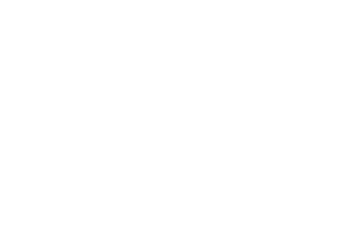

In [10]:
ncg.plot()

We need to load the images into the ncg using 'add_from_filelist', which loads the images from a passed in list and then calculates the overlaps. 

In [11]:
filelist = f'{output_directory}/cubes.lis' # this should contain absolute paths
ncg.add_from_filelist(filelist) 

loading 1 of 69
loading 2 of 69
loading 3 of 69
loading 4 of 69
loading 5 of 69
loading 6 of 69
loading 7 of 69
loading 8 of 69
loading 9 of 69
loading 10 of 69
loading 11 of 69
loading 12 of 69
loading 13 of 69
loading 14 of 69
loading 15 of 69
loading 16 of 69
loading 17 of 69
loading 18 of 69
loading 19 of 69
loading 20 of 69
loading 21 of 69
loading 22 of 69
loading 23 of 69
loading 24 of 69
loading 25 of 69
loading 26 of 69
loading 27 of 69
loading 28 of 69
loading 29 of 69
loading 30 of 69
loading 31 of 69
loading 32 of 69
loading 33 of 69
loading 34 of 69
loading 35 of 69
loading 36 of 69
loading 37 of 69
loading 38 of 69
loading 39 of 69
loading 40 of 69
loading 41 of 69
loading 42 of 69
loading 43 of 69
loading 44 of 69
loading 45 of 69
loading 46 of 69
loading 47 of 69
loading 48 of 69
loading 49 of 69
loading 50 of 69
loading 51 of 69
loading 52 of 69
loading 53 of 69
loading 54 of 69
loading 55 of 69
loading 56 of 69
loading 57 of 69
loading 58 of 69
loading 59 of 69
loadin

Now when we plot the ncg, we see the undirected graph, where the circles are the nodes/images and the lines are the edges/overlaps. The Kaguya TC data has a very regular overlap pattern in this area, seen by the large number of edges shared between nodes.

<AxesSubplot:>

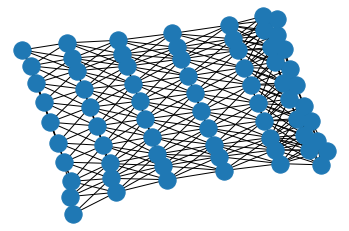

In [12]:
ncg.plot()

We have access to the image data through the ncg, but the ncg does not persist after the notebook is shut down. To persist the network, AutoCNet leverages a database for the storage of the networks images, points, and measures. The ncg has access to this database through the ncg's 'session_scope'. Through the session_scope you can interact and execute queries on your database in pure SQL.

In [14]:
with ncg.session_scope() as session:
    img_count = session.execute("SELECT COUNT(*) FROM images").fetchall()
    overlap_count = session.execute("SELECT COUNT(*) FROM overlay").fetchall()
    print('  Number of images in database: ', img_count[0][0])
    print('Number of overlaps in database: ', overlap_count)
print('Hello')

  Number of images in database:  69
Number of overlaps in database:  [(717,)]
Hello


session.execute() is a convenient if you are already familiar with pure sql commands, however, the return values are messy. The ncg.session_scope() leverages a python module called sqlalchemy which allow pythonic calls to your database with clean output.

In [15]:
from autocnet.io.db.model import Images, Overlay

with ncg.session_scope() as session:
    img_count = session.query(Images).count()
    overlap_count = session.query(Overlay).count()
    print('  Number of images in database: ', img_count)
    print('Number of overlaps in database: ', overlap_count)

  Number of images in database:  69
Number of overlaps in database:  717


Additionally, session.execute() can be inconvenient if working with the actual data contained within the tables. For example, to access certain information you need to know the index where that information exists.

In [19]:
with ncg.session_scope() as session:
    img = session.execute("SELECT * FROM images LIMIT 1").fetchall()
    print('image index: ', img[0][0])
    print('product id: ', img[0][1])
    print('image path: ', img[0][2])
    print('image serial number: ', img[0][3])
    print('image ignore flag: ', img[0][4])
    print('image geom: ', img[0][5]) # only uncomment after looking at other output
    print('image camera type: ', img[0][7])

image index:  1
product id:  TC1W2B0_01_00570N049E3038.cub
image path:  /scratch/ladoramkershner/FY21_autocnet_workshop/workshop_scratch/ladoramkershner/lvl1/TC1W2B0_01_00570N049E3038.cub
image serial number:  KAGUYA/TC1/2007-11-25T07:15:45.203264
image ignore flag:  False
image geom:  010600002034310E00010000000103000000010000009303000063CE081463F17240E45820F96A9010408CED2A4C72F1724005495D286390104046DB48CB80F172403D5EF8EB64901040EB2C564A8FF172407550E5AE66901040133B62CA9DF17240D8BC0FD3689010400B5E6B4AACF1724052A46FFC6A9010401A9583CBBAF17240F713F98E6D901040ADD9E84CC9F172401EB32645709010403ADCB7CED7F1724095A90F2A739010408982DD50E6F1724000A5543776901040A44106D4F4F17240714CB7AD79901040F1AC495903F2724097E259F77D901040C125AADE11F27240BC0AF657829010402A8A886520F272407CE430558790104094EF45EC2EF272406A41EB538C9010405855A2D43CF27240D8D561EC54901040D22BAAB44AF272405C1645BE19901040BE696B9258F272408A042410DD8F104006AFA47066F27240476A56EC9F8F1040F2AFDDA674F272402E16CD70848F10408FFC1E9883F27240747B2

However, if the structure of the database changes (order of the columns or a column is added/removed) or you cannot remember the order of the columns, working with the database data in this way is be very inconvenient. So AutoCNet built models for each table of the database tables to help interface with them.

In [20]:
from autocnet.io.db.model import Measures, Points

with ncg.session_scope() as session:
    img = session.query(Images).first()
    print('image index: ', img.id)
    print('product id: ', img.name)
    print('image path: ', img.path)
    print('image serial number: ', img.serial)
    print('image ignore flag: ', img.ignore)
    print('image geometry: ', img.geom) # only uncomment after looking at other output
    print('image camera type: ', img.cam_type)

image index:  1
product id:  TC1W2B0_01_00570N049E3038.cub
image path:  /scratch/ladoramkershner/FY21_autocnet_workshop/workshop_scratch/ladoramkershner/lvl1/TC1W2B0_01_00570N049E3038.cub
image serial number:  KAGUYA/TC1/2007-11-25T07:15:45.203264
image ignore flag:  False
image geometry:  MULTIPOLYGON (((303.086689028167 4.14103307018215, 303.090404670417 4.14100325650566, 303.093943867298 4.14100998595637, 303.097483002303 4.14101670527099, 303.101023086275 4.14102487357669, 303.104563159374 4.14103311950119, 303.108104242319 4.14104293246509, 303.111645612308 4.14105327652649, 303.115187376217 4.14106431694599, 303.118729462884 4.14107595876817, 303.122272514762 4.14108916693941, 303.125817573352 4.14110552297702, 303.129362740172 4.14112222136708, 303.132909329756 4.14114125357548, 303.13645579642 4.14116030810724, 303.139851221194 4.14094895693912, 303.143238701564 4.14072320267368, 303.146624011595 4.14049172611079, 303.150009768768 4.1402584960693, 303.153479448286 4.14015365840

In [18]:
print(dir(Images))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__mapper__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__table__', '__tablename__', '__weakref__', '_decl_class_registry', '_geom', '_sa_class_manager', 'bulkadd', 'cam_type', 'cameras', 'create', 'footprint_bodyfixed', 'geom', 'id', 'ignore', 'keypoints', 'latitudinal_srid', 'measures', 'metadata', 'name', 'path', 'serial', 'union']


Accessing the information off of the img object is more intuitive as it is property based instead of index based. Additionally, if you uncommented the geom prints (in the two previous cells) you see that the raw database geometry is stored as a binary string while the Images.geom property is a shapely Multipolygon, which has more directly accessible latitude, longitude information. For example, to plot the geometry all we have to do is...

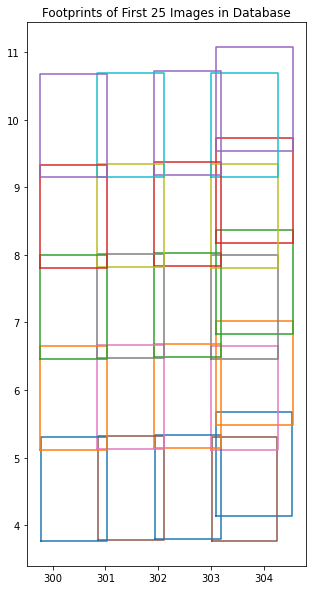

In [21]:
import matplotlib.pyplot as plt
n = 25
with ncg.session_scope() as session:
    imgs = session.query(Images).limit(n)
    
    fig, axs = plt.subplots(1, 1, figsize=(5,10))
    axs.set_title(f'Footprints of First {n} Images in Database')
    for img in imgs:
        x,y = img.geom.envelope.boundary.xy # this call!
        axs.plot(x,y)

<a id="distribute"></a>
# Place Points in Overlap
[Return To Top](#toc)

The next step in the network generation process is to lay down points in the image overlaps. Before dispatching the function to the cluster, we need to make the log directory from our configuration file. If a SLURM job is submitted with a log directory argument that does not exist, the job will fail.

In [22]:
ppio_log_dir = default_log.replace('logs', 'ppio_logs')

print('creating directory: ', ppio_log_dir)
if not os.path.exists(ppio_log_dir):
    os.mkdir(ppio_log_dir)

creating directory:  /scratch/ladoramkershner/FY21_autocnet_workshop/workshop_scratch/ladoramkershner/ppio_logs


We are going to use the 'place_points_in_overlap' function to lay the points down. For now we will use the default size and distribution arguments, but we need to change our camera type from the default 'csm' to 'isis'. 

In [23]:
from autocnet.spatial.overlap import place_points_in_overlap

njobs = ncg.apply('spatial.overlap.place_points_in_overlap', 
                  on='overlaps', # start of function kwargs
                  cam_type='isis',
                  walltime='00:30:00', # start of apply kwargs
                  log_dir=ppio_log_dir,
                  arraychunk=50)

print(njobs)

717


In [24]:
!squeue -u $uid | head # helpful to grab job array id

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON) 
29521163_[1-717%50   longall AutoCNet ladoramk PD       0:00      1 (None) 
          29493840   longall jupyter- ladoramk  R    2:46:25      1 neb1 


This function first evenly distributes points spatially into a given overlap, then it back-projects the points into the 'top' image. Once in image space, the function searches the area surrounding the measures to find interesting features to shift the measures to (this increases the chance of subpixel registration passing). The shifted measures are projected back to the ground and these updated longitudes and latitudes are used to propagate the points into all images associated with the overlap. So, this function requires:
- An overlap (to evenly distribute points into)
- Distribution kwargs (to decide how points are distributed into the overlap)
- Size of the area around the measure (to search for the interesting feature)
- Camera type (so it knows what to expect as inputs/output for the camera model)

Since this function operates independently on each overlap, it is ideal for parallelization with the cluster. Notice that we are not passing in a single overlap to the apply call, instead we pass "on = 'overlaps'". The 'on' argument indicates which element (image, overlap, point, measure) to apply the function. 

In [25]:
with ncg.session_scope() as session:
    noverlay = session.query(Overlay).count()
    print(noverlay)

717


### Multiple Ways to Check Job Array Process

#### Log Files
As jobs are put on the cluster, their corresponding log files are created. You can check how many jobs have been/ are being processed on the cluster by looking in the log directory.

In [26]:
!ls $ppio_log_dir | head -5

autocnet.spatial.overlap.place_points_in_overlap-29521164.29521163_1.out
autocnet.spatial.overlap.place_points_in_overlap-29521165.29521163_2.out
autocnet.spatial.overlap.place_points_in_overlap-29521166.29521163_3.out
autocnet.spatial.overlap.place_points_in_overlap-29521167.29521163_4.out
autocnet.spatial.overlap.place_points_in_overlap-29521168.29521163_5.out
ls: write error: Broken pipe


As more logs are placed in the log directory, you will have to specify which array job's logs you are checking on. The naming convention of the log files generated by AutoCNet are 'path.to.function.function_name-jobid.arrayid_taskid.out'

In [27]:
jobid = '29521163' # put jobid int here
!ls $ppio_log_dir/*${jobid}_*.out | wc -l

668


#### Slurm Account
Using 'sacct' allows you to check the exit status of the tasks from your job array.

In [28]:
!sacct -j $jobid -s 'completed' | wc -l
!sacct -j $jobid -s 'failed'    | wc -l
!sacct -j $jobid -s 'timeout'   | wc -l
!sacct -j $jobid -s 'cancelled' | wc -l

1292
2
2
2


The return of '2' from the word count on the 'failed', 'timeout', and 'cancelled' job accounts are the header lines

In [29]:
!sacct -j $jobid -s 'failed' | head

       JobID    JobName  Partition    Account  AllocCPUS      State ExitCode 
------------ ---------- ---------- ---------- ---------- ---------- -------- 


#### NCG Queue Length
The queue holds the job packages in json files called 'queue messages' until the cluster is ready for the job. You can view how many messages are left on the queue with the 'queue_length' NCG property.

In [30]:
print("jobs left on the queue: ", ncg.queue_length)

jobs left on the queue:  0


### When your squeue is empty
Sometimes jobs fail to submit to the cluster, it is prudent to check the ncg.queue_length AFTER your squeue is empty.

In [35]:
!squeue -u $uid

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON) 
          29493840   longall jupyter- ladoramk  R    2:52:38      1 neb1 


In [34]:
print("jobs left on the queue: ", ncg.queue_length)

jobs left on the queue:  0


When reapplying a function to the cluster, you do not need to resubmit the function arguments, because those were already serialized into the queue message. However, the cluster submission arguments can be reformatted and the 'reapply' argument should be set to 'True'.

In [ ]:
# njobs = ncg.apply('spatial.overlap.place_points_in_overlap', 
#                         chunksize=redis_orphans,
#                         arraychunk=None,
#                         walltime='00:20:00',
#                         log_dir=ppio_log_dir,
#                         reapply=True)
# print(njobs)

One advantage of using of a database for data storage is that it allows for storage of and therefore quick access of geometries and how those geometries relate with other elements' geometries.

number of points:  27


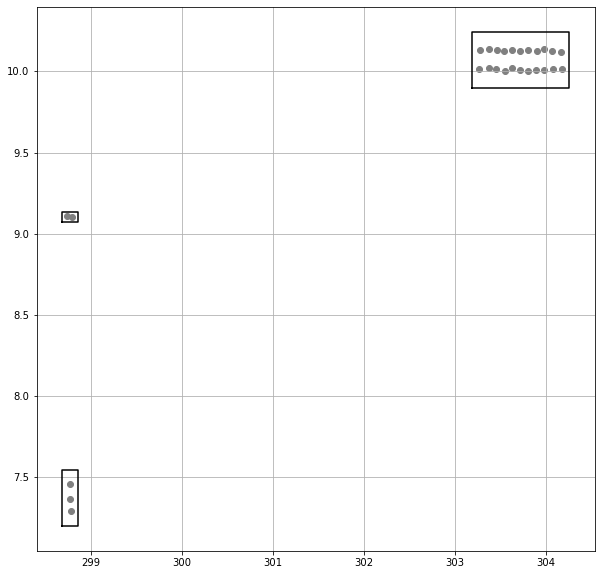

In [36]:
from autocnet.io.db.model import Overlay, Points, Measures
from geoalchemy2 import functions
from geoalchemy2.shape import to_shape


with ncg.session_scope() as session:
    results = (
        session.query(
        Overlay.id, 
        Overlay.geom.label('ogeom'), 
        Points.geom.label('pgeom')
        )
        .join(Points, functions.ST_Contains(Overlay.geom, Points.geom)=='True')
        .filter(Overlay.id < 10)
        .all()
    )
    print('number of points: ', len(results))
    
    fig, axs = plt.subplots(1, 1, figsize=(10,10))
    axs.grid()
    
    oid = []
    for res in results:
        if res.id not in oid:
            oid.append(res.id)
            ogeom = to_shape(res.ogeom)
            ox, oy = ogeom.envelope.boundary.xy
            axs.plot(ox, oy, c='k')      
        pgeom = to_shape(res.pgeom)
        px, py = pgeom.xy
        axs.scatter(px, py, c='grey')
        

Notice that the points are not in straight lines, this is because of the shifting place_points_in_overlap does to find interesting measure locations. 

However, the default distribution of points in the overlaps looks sparse, so let’s rerun place_points_in_overlap with new distribution kwargs. Before rerunning place_point_in_overlap, the points and measures tables need to be cleared using ncg's 'clear_db' method.

In [37]:
from autocnet.io.db.model import Measures

with ncg.session_scope() as session:
    npoints = session.query(Points).count()
    print('number of points: ', npoints)
    
    nmeas = session.query(Measures).count()
    print('number of measures: ', nmeas)

number of points:  2688
number of measures:  8226


In [38]:
ncg.clear_db(tables=['points', 'measures'])

In [39]:
with ncg.session_scope() as session:
    npoints = session.query(Points).count()
    print('number of points: ', npoints)
    
    nmeas = session.query(Measures).count()
    print('number of measures: ', nmeas)

number of points:  0
number of measures:  0


The distribution argument for place_points_in_overlap requires two **function** inputs. Since overlaps are variable shapes and sizes, integers are not sufficient to determine proper gridding of all overlaps. Instead, the distribution of points along the N to S edge of the overlap and the E to W edge of the overlap are determined based on the edge's length and a grid is built from these edge distributions. This way a shorter edge will receive less points and a longer side will receive more points.

The default distribution functions are: <br />
nspts_func=lambda x: ceil(round(x,1)\*10) <br />
ewpts_func=lambda x: ceil(round(x,1)\*5) <br />

** NOTICE THE NS ACTUALLY GETS USED ON THE LONGER SIDE OF THE OVERLAP, NOT NECESSARILY THE NS SIDE**

overlaps in selected area:  163
  points in selected area:  1522


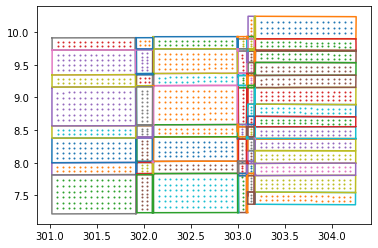

In [42]:
from autocnet.cg.cg import distribute_points_in_geom
import matplotlib.pyplot as plt

def ns(x):
    from math import ceil
    return ceil(round(x,1)*15)

def ew(x):
    from math import ceil
    return ceil(round(x,1)*10)

total=0
with ncg.session_scope() as session:
    srid = config['spatial']['latitudinal_srid']
    overlaps = session.query(Overlay).filter(Overlay.geom.intersects(functions.ST_GeomFromText('LINESTRING(301.2 7.4, 303.7 7.4, 303.7 9.9, 301.2 9.9, 301.2 7.4)', srid))).all()
    
    print('overlaps in selected area: ', len(overlaps))
    for overlap in overlaps:
        ox, oy = overlap.geom.exterior.xy
        plt.plot(ox,oy)
        
        valid = distribute_points_in_geom(overlap.geom, method='classic', nspts_func=ns, ewpts_func=ew, Session=session)
        if valid:
            total += len(valid)
            px, py = list(zip(*valid))
            plt.scatter(px, py, s=1)

    print('  points in selected area: ', total)

In [43]:
distribute_points_kwargs = {'nspts_func':ns, 'ewpts_func':ew, 'method':'classic'}

njobs = ncg.apply('spatial.overlap.place_points_in_overlap', 
                  on='overlaps', # start of function kwargs
                  distribute_points_kwargs=distribute_points_kwargs, # NEW LINE
                  cam_type='isis',
                  size=71,
                  walltime='00:30:00', # start of apply kwargs
                  log_dir=ppio_log_dir,
                  arraychunk=100)
print(njobs)

717


In [48]:
from autocnet.matcher.cpu_extractor import extract_most_interesting

extract_most_interesting?

Check the progress of your jobs

In [59]:
!squeue -u $uid | wc -l
!squeue -u $uid | head

5
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON) 
      29524102_677   longall AutoCNet ladoramk  R       4:01      1 neb2 
      29524102_633   longall AutoCNet ladoramk  R       4:22      1 neb4 
      29524102_600   longall AutoCNet ladoramk  R       4:35      1 neb3 
          29493840   longall jupyter- ladoramk  R    3:05:19      1 neb1 


Count number of jobs started by looking for generated logs

In [51]:
jobid = '29524102' # put jobid int here
! ls  $ppio_log_dir/*$jobid* | wc -l

717


In [79]:
!sacct -j $jobid -s 'completed' | wc -l
!sacct -j $jobid -s 'failed'    | wc -l

15304
2


Check to see if the ncg redis queue is clear

In [80]:
redis_orphans = ncg.queue_length
print("jobs left on the queue: ", redis_orphans)

jobs left on the queue:  0


Reapply cluster job if there are still jobs left on the queue

In [ ]:
# njobs = ncg.apply('spatial.overlap.place_points_in_overlap', 
#                         chunksize=redis_orphans,
#                         arraychunk=None,
#                         walltime='00:20:00',
#                         log_dir=log_dir,
#                         reapply=True)
# print(njobs)

Visualize the new distribution

number of points:  64


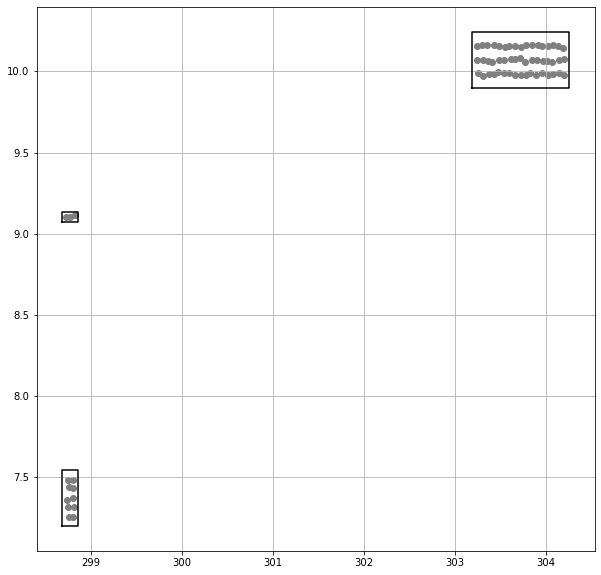

In [57]:
from autocnet.io.db.model import Overlay, Points, Measures
from geoalchemy2 import functions
from geoalchemy2.shape import to_shape


with ncg.session_scope() as session:
    results = (
        session.query(
        Overlay.id, 
        Overlay.geom.label('ogeom'), 
        Points.geom.label('pgeom')
        )
        .join(Points, functions.ST_Contains(Overlay.geom, Points.geom)=='True')
        .filter(Overlay.id < 10)
        .all()
    )
    print('number of points: ', len(results))
    
    fig, axs = plt.subplots(1, 1, figsize=(10,10))
    axs.grid()
    
    oid = []
    for res in results:
        if res.id not in oid:
            oid.append(res.id)
            ogeom = to_shape(res.ogeom)
            ox, oy = ogeom.envelope.boundary.xy
            axs.plot(ox, oy, c='k')      
        pgeom = to_shape(res.pgeom)
        px, py = pgeom.xy
        axs.scatter(px, py, c='grey')
        

<a id="registration"></a>
# Subpixel Registration
[Return To Top](#toc)

After laying down points, the next step is to subpixel register the measures on those points, to do this we are going to use the 'subpixel_register_point' function. As the name suggests, 'subpixel_register_point' registers the measures on a single point, which makes it parallelizable. Before we fire off the cluster jobs, let's create a new subpixel registration log directory.

In [61]:
subpix_log_dir = default_log.replace('logs', 'subpix_logs')

print('creating directory: ', subpix_log_dir)
if not os.path.exists(subpix_log_dir):
    os.mkdir(subpix_log_dir)

creating directory:  /scratch/ladoramkershner/FY21_autocnet_workshop/workshop_scratch/ladoramkershner/subpix_logs


## First Run

In [66]:
from autocnet.matcher.subpixel import subpixel_register_point

?subpixel_register_point
# ncg.apply?

In [65]:
subpixel_template_kwargs = {'image_size':(81,81), 'template_size':(51,51)} 

njobs = ncg.apply('matcher.subpixel.subpixel_register_point', 
                  on='points', # start of function kwargs
                  match_kwargs=subpixel_template_kwargs,
                  geom_func='simple',
                  match_func='classic',
                  cost_func=lambda x,y:y,
                  threshold=0.6, 
                  verbose=False,
                  walltime="00:30:00", # start of apply kwargs
                  log_dir=subpix_log_dir,
                  arraychunk=200,
                  chunksize=20000) # maximum chunksize = 20,000

print(njobs)

7651


Check the progress of your jobs

In [77]:
!squeue -u $uid | head

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON) 
     29525915_3953   longall AutoCNet ladoramk CG       1:08      1 neb4 
29525915_[4536-765   longall AutoCNet ladoramk PD       0:00      1 (JobArrayTaskLimit) 
     29525915_4535   longall AutoCNet ladoramk  R       0:00      1 neb15 
     29525915_4529   longall AutoCNet ladoramk  R       0:01      1 neb13 
     29525915_4530   longall AutoCNet ladoramk  R       0:01      1 neb13 
     29525915_4531   longall AutoCNet ladoramk  R       0:01      1 neb13 
     29525915_4532   longall AutoCNet ladoramk  R       0:01      1 neb13 
     29525915_4533   longall AutoCNet ladoramk  R       0:01      1 neb6 
     29525915_4534   longall AutoCNet ladoramk  R       0:01      1 neb7 


This function chooses a reference measure, affinely transforms the other images to the reference image, and clips an 'image' chip out of the reference image and a 'template' chip out of the transformed images. The template chips are marched across the image chip and the maximum correlation value and location is saved. 

The solution is then evaluated to see if the maximum correlation solution is acceptable. The evaluation is done using the 'cost_func' and 'threshold' arguments. The cost_func is dependent two independent variables, the first is the distance that a point has shifted from the starting location and the second is the correlation coefficient coming out of the template matcher. The __order__ that these variables are passed in __matters__. We are not going to consider the distance the measures were moved and just look at the maximum correlation value returned by the matcher. So our function is simply: $y$.

If the cost_func solution is greater than the threshold value, the registration is successful and the point is updated. If not, the registration is unsuccessful, the point is not updated and is set to ignore.

So, 'subpixel_register_point' requires the following arguments:
- pointid
- match_kwargs (image size, template size)
- cost_func 
- threshold

In [ ]:
from autocnet.matcher.subpixel import subpixel_register_point

subpixel_register_point?

Count number of jobs started by looking for generated logs

In [70]:
jobid = '29525915' # put jobid int here
! ls $subpix_log_dir/*$jobid* | wc -l

3215


In [71]:
!sacct -j $jobid -s 'completed' | wc -l
!sacct -j $jobid -s 'failed'    | wc -l

6048
2


Check to see if the ncg redis queue is clear

In [72]:
redis_orphans = ncg.queue_length
print("jobs left on the queue: ", redis_orphans)

jobs left on the queue:  4426


Reapply cluster job if there are still jobs left on the queue

In [ ]:
# job_array = ncg.apply('matcher.subpixel.subpixel_register_point', 
#                       reapply=True,
#                       chunksize=redis_orphans, 
#                       arraychunk=None,
#                       walltime="00:30:00",
#                       log_dir=subpix1_log_dir)
# print(job_array)

### Visualize Point Registration

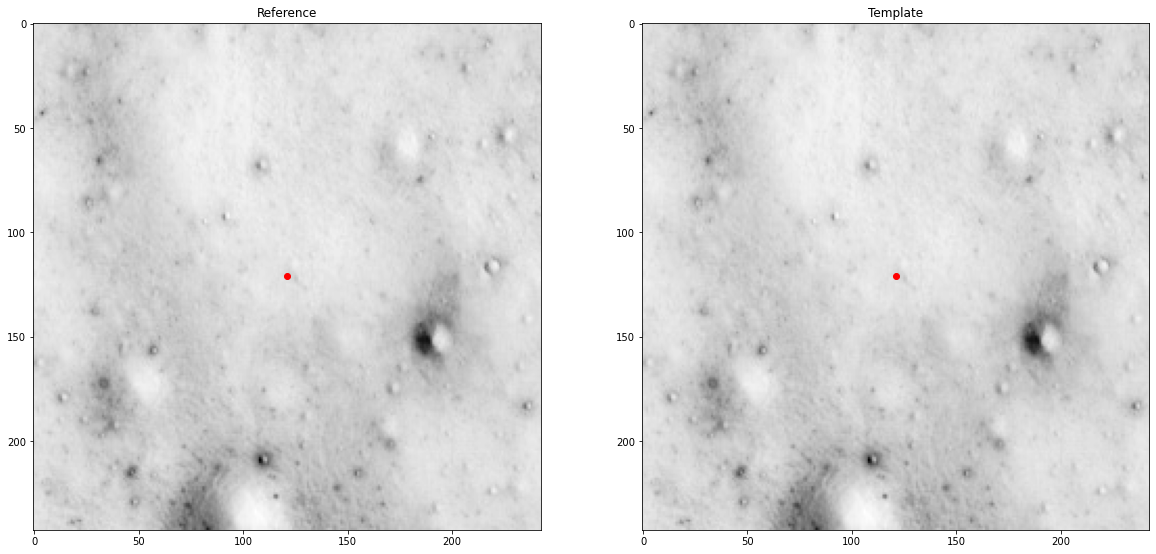

In [76]:
from autocnet.io.db.model import Images
from plio.io.io_gdal import GeoDataset
from autocnet.transformation import roi
from autocnet.utils.utils import bytescale

with ncg.session_scope() as session:
    measures = session.query(Measures).filter(Measures.template_metric < 0.8, Measures.template_metric!=1).limit(15)
    for meas in measures:
        pid = meas.pointid
        source = session.query(Measures, Images).join(Images, Measures.imageid==Images.id).filter(Measures.pointid==pid, Measures.template_metric==1).all()
        s_img = GeoDataset(source[0][1].path)
        sx = source[0][0].sample
        sy = source[0][0].line
    
        destination = session.query(Measures, Images).join(Images, Measures.imageid==Images.id).filter(Measures.pointid==pid, Measures.template_metric!=1).limit(1).all()
        d_img = GeoDataset(destination[0][1].path)
        dx = destination[0][0].sample
        dy = destination[0][0].line
    
    
        image_size = (121,121)
        template_size = (61,61)
        s_roi = roi.Roi(s_img, sx, sy, size_x=image_size[0], size_y=image_size[1])
        s_image = bytescale(s_roi.clip())

        d_roi = roi.Roi(d_img, dx, dy, size_x=image_size[0], size_y=image_size[1])
        d_template = bytescale(d_roi.clip())

        fig, axs = plt.subplots(1, 2, figsize=(20,10));
        axs[0].imshow(s_image, cmap='Greys');
        axs[0].scatter(image_size[0], image_size[1], c='r')
        axs[0].set_title('Reference');
        axs[1].imshow(d_template, cmap='Greys');
        axs[1].scatter(image_size[0], image_size[1], c='r')
        axs[1].set_title('Template');


## Second run
We are going to rerun the subpixel registration with larger chips to attempt to register the measures that failed first run. 'subpixel_register_point' is set up so subsequent runs can use filters which only runs the function on points with a certain property value (e.g.: points where ignore=true). It can also be rerun on all points, if this is done AutoCNet checks for a previous subpixel registration result, if the new result is better the point is updated, if the previous result is better the point is left alone.

In [78]:
ncg.apply?

In [ ]:
subpixel_template_kwargs = {'image_size':(221,221), 'template_size':(81,81)} 
filters = {'ignore': 'true'}
# query = "SELECT UNIQUE(measures.pointid) FROM measures WHERE template_metric < 0.65"

njobs = ncg.apply('matcher.subpixel.subpixel_register_point', 
                  on='points', # start of function kwargs
#                   filters=filters,  ##### NEW LINE
                  query_string=query,
                  match_kwargs=subpixel_template_kwargs,
                  geom_func='simple',
                  match_func='classic',
                  cost_func=lambda x,y:y,
                  threshold=0.6, 
                  verbose=False,
                  walltime="00:30:00", # start of apply kwargs
                  log_dir=subpix_log_dir,
                  arraychunk=50,
                  chunksize=20000) # maximum chunksize = 20,000

print(njobs)

Check the progress of your jobs

In [ ]:
! squeue -u $uid | wc -l
! squeue -u $uid | head

Count number of jobs started by looking for generated logs

In [ ]:
jobid = '' # put jobid int here
! ls $log_dir/*$jobid* | wc -l

Check to see if the ncg redis queue is clear

In [ ]:
redis_orphans = ncg.queue_length
print("jobs left on the queue: ", redis_orphans)

Reapply cluster job if there are still jobs left on the queue

In [ ]:
# njobs = ncg.apply('matcher.subpixel.subpixel_register_point', 
#                   reapply = True,
#                   walltime="00:30:00",
#                   log_dir='/scratch/ladoramkershner/mars_quads/oxia_palus/subpix2_logs/',
#                   arraychunk=50,
#                   chunksize=20000) # maximum chunksize = 20,000

# print(njobs)

### subpix2: Write out Network
At this point you write out the network to begin work bundling the network!

In [ ]:
cnet = 'reiner_gamma_morning_ns7_ew5_t121x61_t221x81.net'
ncg.to_isis(os.path.join(output_directory,cnet))